In [75]:
# LSTM Autoencoder를 이용한 이상 온도 탐지
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from myProcessData import myProcessData
from myTimedistributed import TimeDistributed

# 데이터 준비
all_data = []
data = pd.read_csv('csv/pjh_multi_data.csv')
# data = data['temperature'].values
all_data.append(data['temperature'].values)
all_data.append(data['humidity'].values)
all_data.append(data['ammonia'].values)


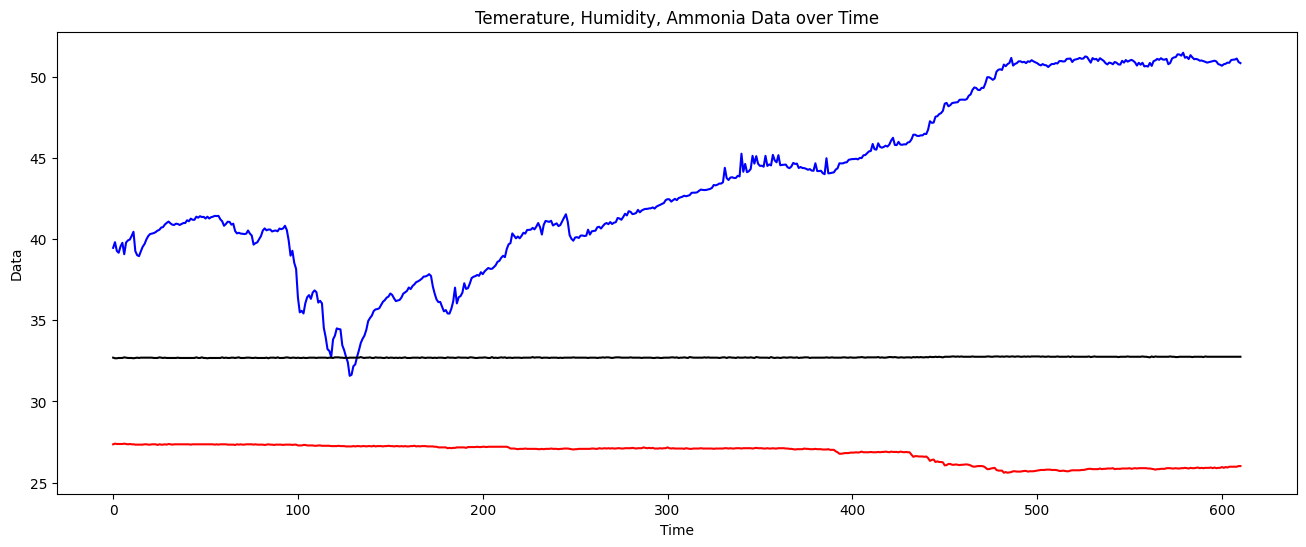

In [76]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(range(len(all_data[0])), all_data[0], 'r')
ax.plot(range(len(all_data[1])), all_data[1], 'b')
ax.plot(range(len(all_data[2])), all_data[2], 'k')
ax.set_xlabel('Time')
ax.set_ylabel('Data')
plt.title('Temerature, Humidity, Ammonia Data over Time')
plt.show()

In [77]:
# 모델 정의 및 학습 --------------------------------------
# 모델 구성
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, batch_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.dense1 = nn.Linear(input_size, hidden_size*2)
        self.encoder1 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size*2, batch_first=True)
        self.encoder2 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size, batch_first=True)
    
    def forward(self, x): # (16, 1, 3)
        processed_output = self.dense1(x)
        # encoded_output1, _ = self.encoder1(processed_output)   # (16, 1, 128)
        _, hidden_state = self.encoder2(processed_output) # (16, 1, 64), (1, 16, 64)
        # Need batch_size operation. Data length[-1] != batch_size
        reshaped_tensor = hidden_state[0].reshape(self.batch_size, 1, self.hidden_size) # (16, 1, 64)
        expanded_tensor= reshaped_tensor.expand(-1, self.sequence_length, -1)   # (16, sequence_length, 64)
        return expanded_tensor


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length):
        super(Decoder, self).__init__()
        self.decoder1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.decoder2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.timedistributed = TimeDistributed(nn.Linear(hidden_size*2, input_size))
    
    def forward(self, x): # (16, sequence_length, 64)
        decoded_output1, _ = self.decoder1(x)   # (16, 1, 64)
        decoded_output2, _ = self.decoder2(decoded_output1) # (16, 1, 128)
        distributer_output = self.timedistributed(decoded_output2)  # (16, 1, 3)
        return distributer_output


class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, batch_size):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = Encoder(
            input_size = input_size,
            hidden_size= hidden_size,
            sequence_length= sequence_length,
            batch_size=batch_size
        )
        self.decoder = Decoder(
            input_size = input_size,
            hidden_size= hidden_size,
            sequence_length= sequence_length
        )

    def forward(self, x):
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)

        return decoded_output

sequence_length = 1  # 시퀀스 길이 설정
input_size = 3  # 변수 개수
hidden_size = 32
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM_Autoencoder(input_size, hidden_size, sequence_length, batch_size).to(device)
# 손실 함수 정의
loss_function = nn.MSELoss()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

# K-fold Cross Validation
k = 1  # Number of folds
fold_losses = []
test_losses = []  # List to store the test losses
result_fold_loss = []
rebuild_result = [[],[],[]]
# K-fold data splitting
for i in range(k):
    print(f"Fold {i+1}")
    train_subset_dataloader, test_subset_dataloader = myProcessData(
        all_data, len(all_data), batch_size)
    # ------------------------------------------------------------

    # 모델 초기화
    model = LSTM_Autoencoder(input_size, hidden_size, sequence_length, batch_size).to(device)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 학습
    fold_loss = []
    num_epochs = 100  # 학습 횟수 설정
    for epoch in range(num_epochs):
        print(f"epochs: {epoch}")
        for data in train_subset_dataloader:
            
            # 순전파
            optimizer.zero_grad()
            data = data.to(device)
            outputs = model(data)

            # 각 기체별 loss 따로 뽑아서 loss_list에 저장
            loss_list = []
            for loss_count in range(input_size):
                loss = loss_function(outputs[:,0,loss_count].reshape(-1, 1), data[:,0,loss_count].reshape(-1, 1))
                loss_list.append(loss)
            
            # 전체 loss 역전파
            loss = loss_function(outputs.reshape(-1, input_size), data.reshape(-1, input_size))
            loss.backward()
            optimizer.step()
            if epoch == num_epochs - 1 :
                for i in range(input_size):
                    rebuild_result[i].append(outputs[:,0,i])
        fold_loss.append(loss_list)

    test_subset_loss = []
    # 테스트 데이터에 대한 재구성 오차 계산
    with torch.no_grad():
        for data in test_subset_dataloader:
            data = data.to(device)
            test_subset_outputs = model(data)
            test_subset_loss.append(loss_function(test_subset_outputs, data))

    # Append the average test loss to test_losses list
    print(f"Loss after training: {fold_loss[-1]}")
    print(f"Fold {i+1} Test loss: {test_subset_loss}")
    print('===========================================================')


Fold 1
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49
epochs: 50
epochs: 51
epochs: 52
epochs: 53
epochs: 54
epochs: 55
epochs: 56
epochs: 57
epochs: 58
epochs: 59
epochs: 60
epochs: 61
epochs: 62
epochs: 63
epochs: 64
epochs: 65
epochs: 66
epochs: 67
epochs: 68
epochs: 69
epochs: 70
epochs: 71
epochs: 72
epochs: 73
epochs: 74
epochs: 75
epochs: 76
epochs: 77
epochs: 78
epochs: 79
epochs: 80
epochs: 81
epochs: 82
epochs: 83
epochs: 84
epochs: 85
epochs: 86
epochs: 87
epochs: 88
epochs: 89
epochs: 90
ep

3


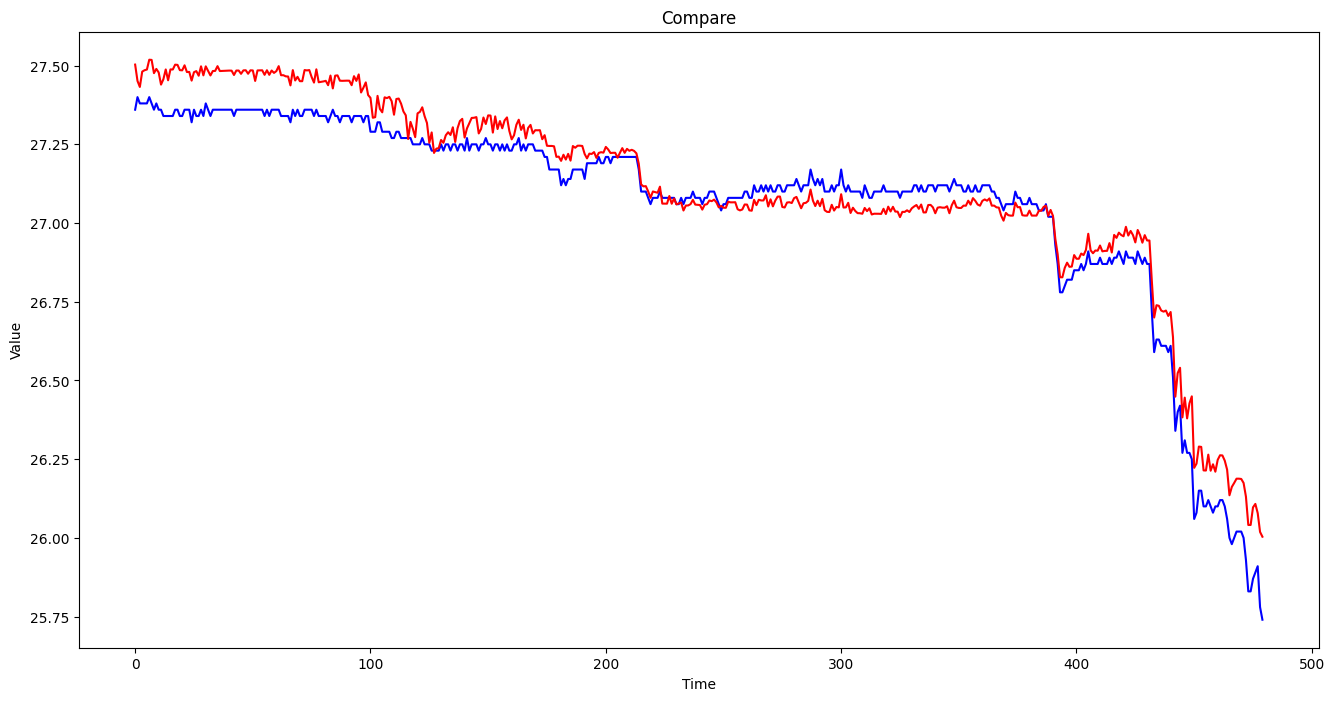

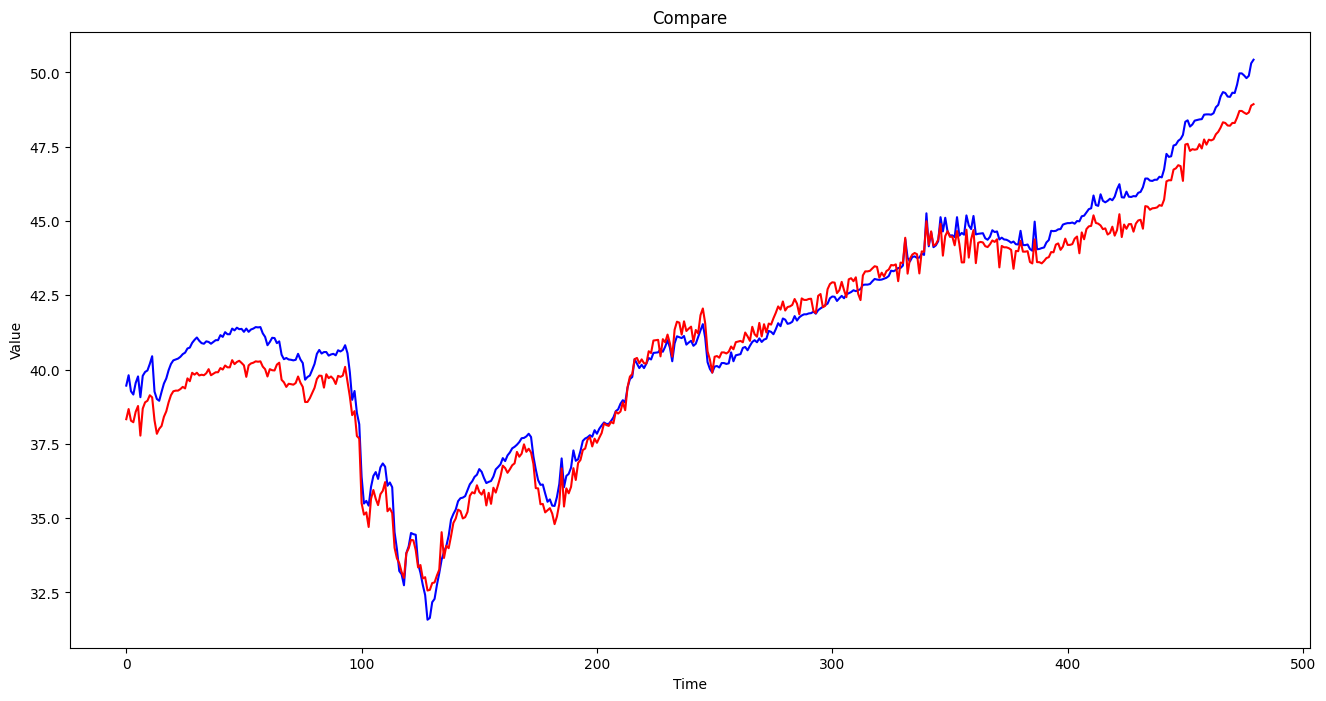

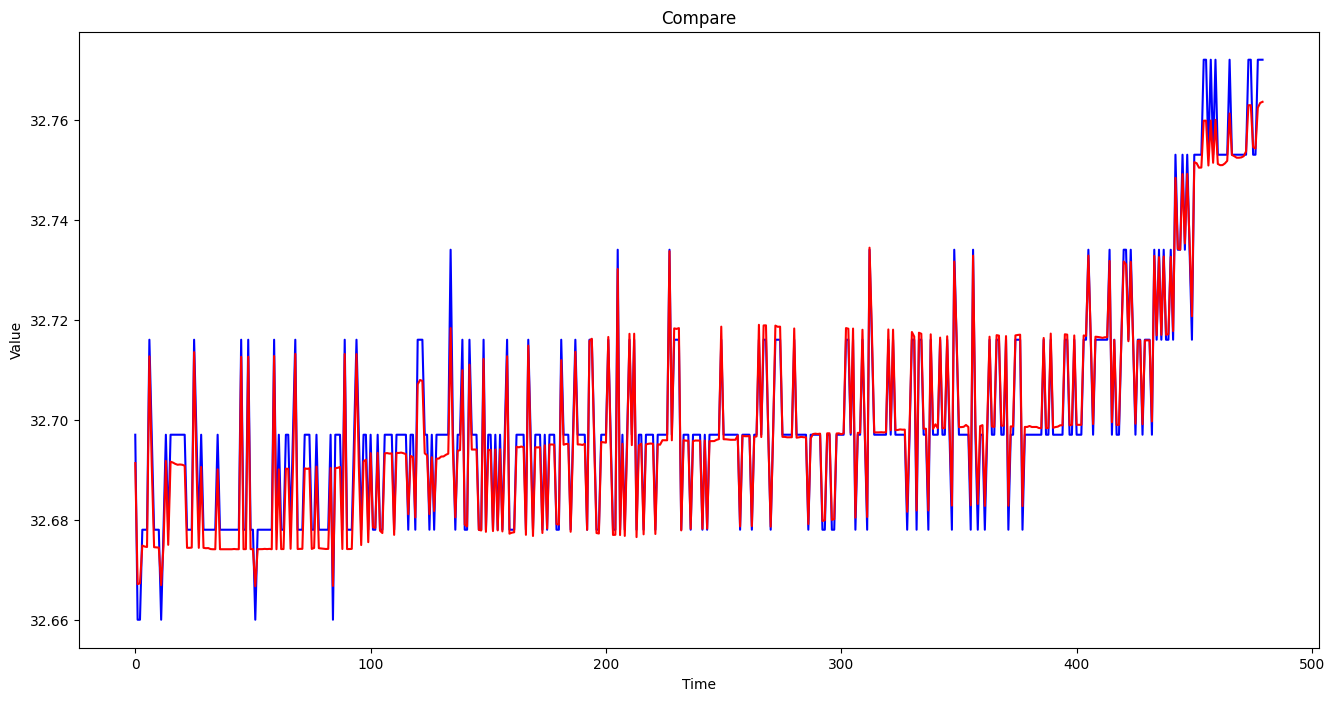

In [78]:
print(len(rebuild_result)) # 온도
temp_rebuild = rebuild_result[0]
temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in temp_rebuild]
temp_rebuild = np.reshape(temp_rebuild_cpu, (-1, 1))
temp_data = all_data[0][:len(temp_rebuild)]
temp_min = np.min(temp_data)
temp_max = np.max(temp_data)
temp_rebuild = (temp_max - temp_min) * temp_rebuild + temp_min

fig, axes = plt.subplots(figsize=(16, 8), sharex=True)
axes.plot(range(len(temp_rebuild)), all_data[0][:len(temp_rebuild)], 'b', label="Original")
axes.plot(range(len(temp_rebuild)), temp_rebuild, 'r', label="Reconstruct")
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.set_title('Compare')
plt.show()

temp_rebuild = rebuild_result[1] # 습도
temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in temp_rebuild]
temp_rebuild = np.reshape(temp_rebuild_cpu, (-1, 1))
temp_data = all_data[1][:len(temp_rebuild)]
temp_min = np.min(temp_data)
temp_max = np.max(temp_data)
temp_rebuild = (temp_max - temp_min) * temp_rebuild + temp_min

fig, axes = plt.subplots(figsize=(16, 8), sharex=True)
axes.plot(range(len(temp_rebuild)), all_data[1][:len(temp_rebuild)], 'b', label="Original")
axes.plot(range(len(temp_rebuild)), temp_rebuild, 'r', label="Reconstruct")
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.set_title('Compare')
plt.show()

temp_rebuild = rebuild_result[2] # Ammonia
temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in temp_rebuild]
temp_rebuild = np.reshape(temp_rebuild_cpu, (-1, 1))
temp_data = all_data[2][:len(temp_rebuild)]
temp_min = np.min(temp_data)
temp_max = np.max(temp_data)
temp_rebuild = (temp_max - temp_min) * temp_rebuild + temp_min

fig, axes = plt.subplots(figsize=(16, 8), sharex=True)
axes.plot(range(len(temp_rebuild)), all_data[2][:len(temp_rebuild)], 'b', label="Original")
axes.plot(range(len(temp_rebuild)), temp_rebuild, 'r', label="Reconstruct")
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.set_title('Compare')
plt.show()

In [79]:
# print(test_losses)
# test_losses_cpu = []
# for sublist in test_losses:
#     cpu_sublist = [tensor.cpu() for tensor in sublist]
#     test_losses_cpu.append(cpu_sublist)
# test_losses_cpu = [[tensor.item() for tensor in sublist] for sublist in test_losses_cpu]
# test_losses_cpu = np.reshape(test_losses_cpu, -1)
# print(test_losses_cpu)
# fig, ax = plt.subplots(figsize=(16, 6))
# ax.bar(range(len(test_losses_cpu)), test_losses_cpu, width=0.5, align='center', color='k')
# plt.title('Training Loss for Test Data')
# plt.show()

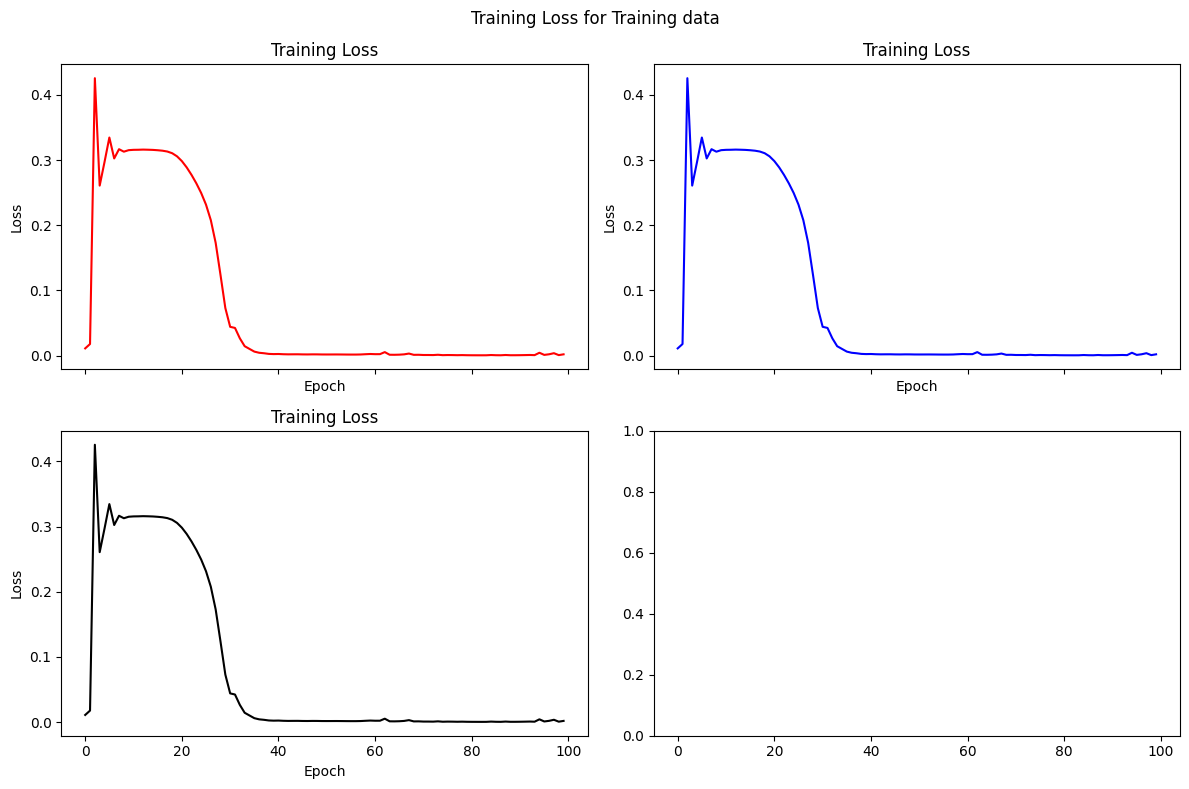

In [80]:
# Plotting the losses for each fold
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
temp_loss = []
humid_loss = []
ammonia_loss = []

for i in range(len(fold_loss)):
    temp_loss.append(fold_loss[i][0])
    humid_loss.append(fold_loss[i][1])
    ammonia_loss.append(fold_loss[i][2])

temp_loss = [tensor.detach().cpu().numpy() for tensor in temp_loss]
humid_loss = [tensor.detach().cpu().numpy() for tensor in humid_loss]
ammonia_loss = [tensor.detach().cpu().numpy() for tensor in ammonia_loss]

axes[0, 0].plot(range(len(temp_loss)), temp_loss, 'r', label="Temperature loss")
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')

axes[0, 1].plot(range(len(temp_loss)), temp_loss, 'b', label="Humidity loss")
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss')

axes[1, 0].plot(range(len(temp_loss)), temp_loss, 'k', label="Ammonia loss")
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss')
plt.suptitle('Training Loss for Training data')
plt.tight_layout()
plt.show()


In [81]:
# 비정상 데이터 생성 =======================================
# 데이터 파일 불러오기
abnormal_data = []
data = pd.read_csv('csv/pjh_multi_data.csv')
abnormal_data.append(data['temperature'].values)
abnormal_data.append(data['humidity'].values)
abnormal_data.append(data['ammonia'].values)

# # Noise case 1 : 정현파 노이즈
# X=np.linspace(0,4*np.pi,len(abnormal_data))
# sin_wave=np.sin(X)
# abnormal_data += -sin_wave

# Noise case 2 : 특정 구간 랜덤 노이즈
start_index = 250
end_index = 350
interval_length = end_index - start_index
noise = np.random.uniform(-0.5, 0.5, interval_length)
abnormal_data[0][start_index:end_index] += noise
abnormal_data[1][start_index:end_index] += 10*noise
abnormal_data[2][start_index:end_index] += noise

start_index = 500
end_index = 550
interval_length = end_index - start_index
noise = np.random.uniform(-0.5, 0.5, interval_length)
# abnormal_data[0][start_index:end_index] += noise
# abnormal_data[1][start_index:end_index] += noise
# abnormal_data[2][start_index:end_index] += noise

# Normalization X -> Standardization
abnormal_max = np.max(abnormal_data[0])
abnormal_min = np.min(abnormal_data[0])
abnormal_data[0] = (abnormal_data[0] - abnormal_min) / (abnormal_max - abnormal_min)

abnormal_max = np.max(abnormal_data[1])
abnormal_min = np.min(abnormal_data[1])
abnormal_data[1] = (abnormal_data[1] - abnormal_min) / (abnormal_max - abnormal_min)

abnormal_max = np.max(abnormal_data[2])
abnormal_min = np.min(abnormal_data[2])
abnormal_data[2] = (abnormal_data[2] - abnormal_min) / (abnormal_max - abnormal_min)


In [82]:

# 3D로 변환
abnormal_data = np.transpose(np.array(abnormal_data))
abnormal_dataset = np.reshape(abnormal_data[:np.prod( (int(np.floor(len(abnormal_data)/input_size)), input_size) )], 
                              (-1, 1, input_size))
# PyTorch 데이터셋 생성
abnormal_dataset = torch.Tensor(abnormal_dataset)
abnormal_dataloader = DataLoader(abnormal_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

abnormal_loss = []
test_rebuild_result = [[],[],[]]
test_losses = []
# 비정상 데이터에 대한 재구성 오차 계산
with torch.no_grad():
    for data in abnormal_dataloader:
        data = data.to(device)
        abnormal_outputs = model(data)
        
        test_loss = []
        for loss_count in range(input_size):
            test_loss.append(loss_function(
                abnormal_outputs[:,0,loss_count].reshape(-1, 1), data[:,0,loss_count].reshape(-1, 1)))
        test_losses.append(test_loss)
        abnormal_loss.append(loss_function(abnormal_outputs, data))
        for i in range(input_size):
            test_rebuild_result[i].append(abnormal_outputs[:,0,i])
print(f'Abnormal data loss: {abnormal_loss}')
abnormal_loss_cpu = [tensor.cpu().numpy() for tensor in abnormal_loss]

test_temp_loss = []
test_humid_loss = []
test_ammonia_loss = []

for i in range(len(test_losses)):
    test_temp_loss.append(test_losses[i][0])
    test_humid_loss.append(test_losses[i][1])
    test_ammonia_loss.append(test_losses[i][2])

test_temp_loss = [tensor.detach().cpu().numpy() for tensor in test_temp_loss]
test_humid_loss = [tensor.detach().cpu().numpy() for tensor in test_humid_loss]
test_ammonia_loss = [tensor.detach().cpu().numpy() for tensor in test_ammonia_loss]

Abnormal data loss: [tensor(0.0012, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(0.0171, device='cuda:0'), tensor(0.0157, device='cuda:0'), tensor(0.0135, device='cuda:0'), tensor(0.0126, device='cuda:0')]


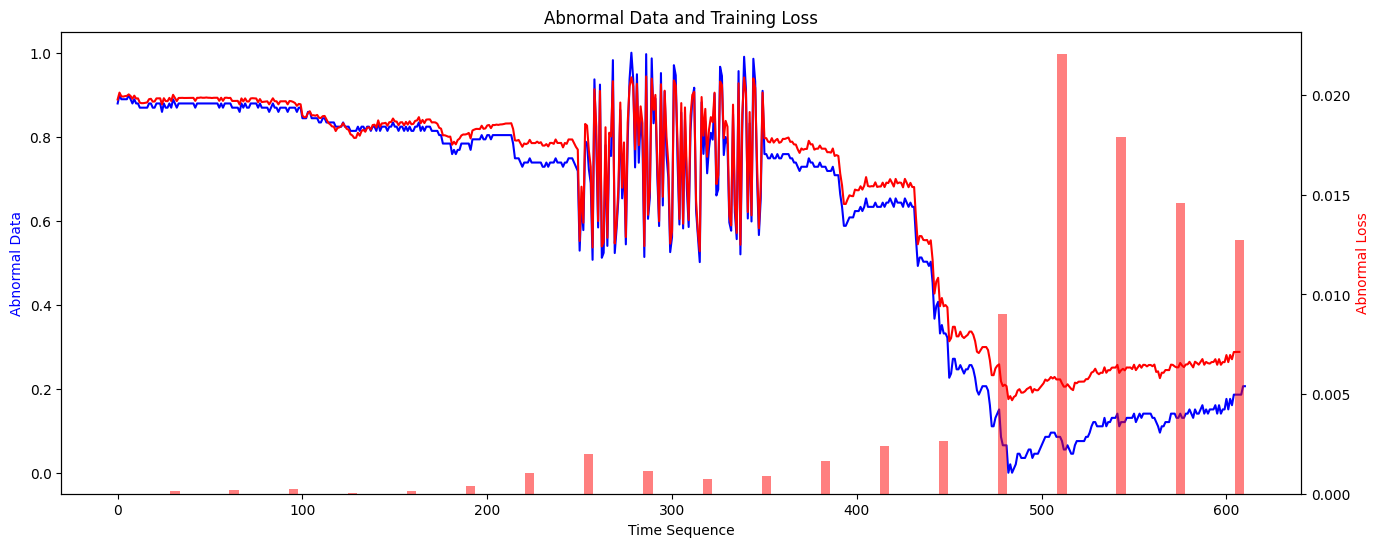

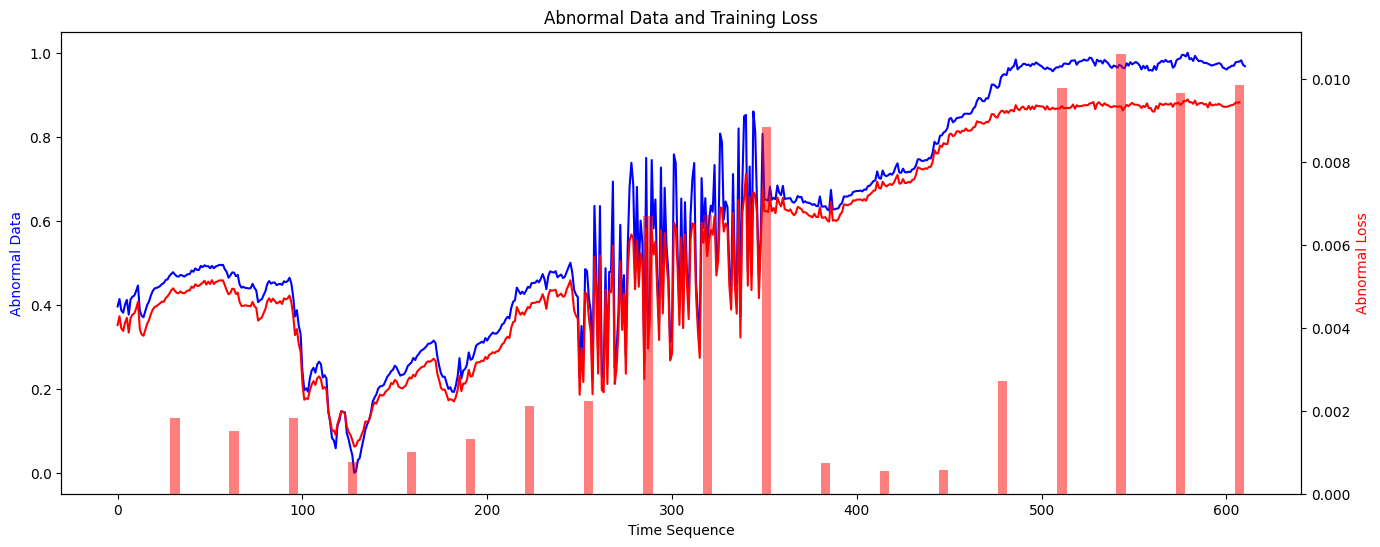

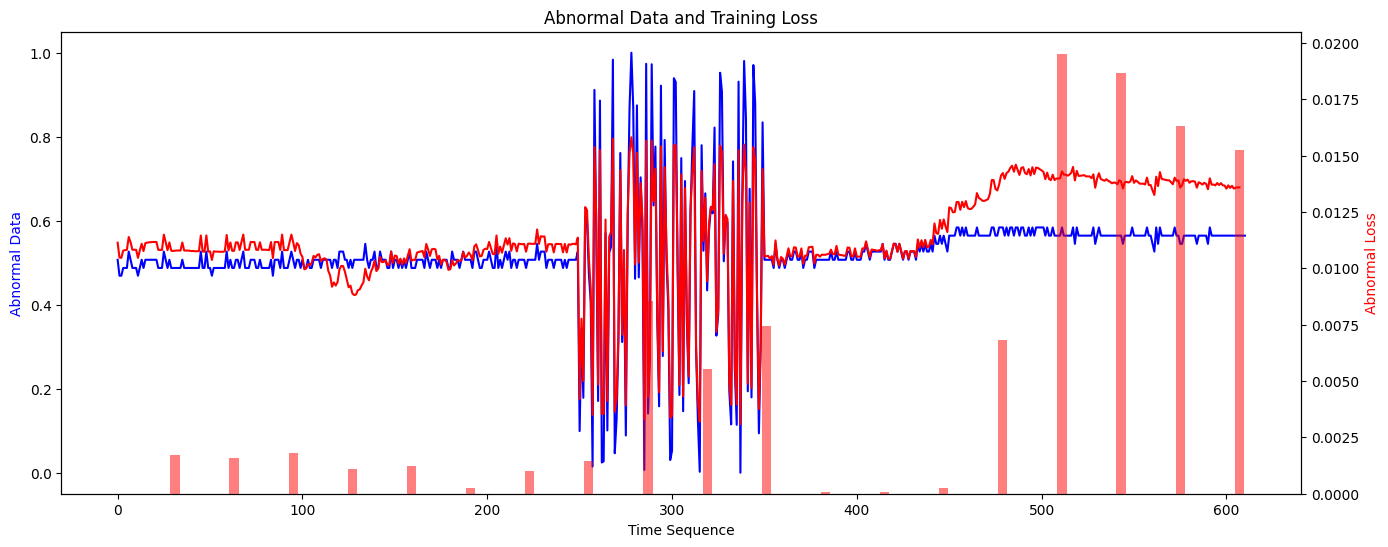

In [83]:
test_temp_rebuild = test_rebuild_result[0]
test_temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in test_temp_rebuild]
test_temp_rebuild = np.reshape(test_temp_rebuild_cpu, (-1, 1))

test_humid_rebuild = test_rebuild_result[1]
test_humid_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in test_humid_rebuild]
test_humid_rebuild = np.reshape(test_humid_rebuild_cpu, (-1, 1))

test_ammonia_rebuild = test_rebuild_result[2]
test_ammonia_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in test_ammonia_rebuild]
test_ammonia_rebuild = np.reshape(test_ammonia_rebuild_cpu, (-1, 1))
# temp_data = all_data[0]
# temp_min = np.min(temp_data)
# temp_max = np.max(temp_data)
# test_temp_rebuild = (temp_max - temp_min) * test_temp_rebuild + temp_min

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(abnormal_data)), abnormal_data[:,0], 'b')
ax1.plot(range(len(test_temp_rebuild)), test_temp_rebuild, 'r')
ax1.set_xlabel('Time Sequence')
ax1.set_ylabel('Abnormal Data', color='b')
ax2 = ax1.twinx()
ax2.bar(np.arange(batch_size - 1, batch_size * len(test_temp_loss), batch_size), test_temp_loss, width=5, align='center', color='r', alpha=0.5)
ax2.set_ylabel('Abnormal Loss', color='r')
plt.title('Abnormal Data and Training Loss')
plt.show()

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(abnormal_data)), abnormal_data[:,1], 'b')
ax1.plot(range(len(test_humid_rebuild)), test_humid_rebuild, 'r')
ax1.set_xlabel('Time Sequence')
ax1.set_ylabel('Abnormal Data', color='b')
ax2 = ax1.twinx()
ax2.bar(np.arange(batch_size - 1, batch_size * len(test_humid_loss), batch_size), test_humid_loss, width=5, align='center', color='r', alpha=0.5)
ax2.set_ylabel('Abnormal Loss', color='r')
plt.title('Abnormal Data and Training Loss')
plt.show()

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(abnormal_data)), abnormal_data[:,2], 'b')
ax1.plot(range(len(test_ammonia_rebuild)), test_ammonia_rebuild, 'r')
ax1.set_xlabel('Time Sequence')
ax1.set_ylabel('Abnormal Data', color='b')
ax2 = ax1.twinx()
ax2.bar(np.arange(batch_size - 1, batch_size * len(test_ammonia_loss), batch_size), test_ammonia_loss, width=5, align='center', color='r', alpha=0.5)
ax2.set_ylabel('Abnormal Loss', color='r')
plt.title('Abnormal Data and Training Loss')
plt.show()

In [84]:
print(model)

LSTM_Autoencoder(
  (encoder): Encoder(
    (dense1): Linear(in_features=3, out_features=64, bias=True)
    (encoder1): LSTM(64, 64, batch_first=True)
    (encoder2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (decoder1): LSTM(32, 32, batch_first=True)
    (decoder2): LSTM(32, 64, batch_first=True)
    (timedistributed): TimeDistributed(
      (module): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)
